In [2]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

Funcion para encontrar el mejor k

In [3]:
def encontrar_k_optimo(datos_imagen, max_k=20):
    """
    Determina el valor óptimo de k utilizando múltiples métodos
    """
    print("Analizando el valor óptimo de k...")

    # 1. Método del codo
    sse = []
    rango_k = range(2, max_k+1)

    # Para acelerar los cálculos, usar una muestra
    tamano_muestra = min(100000, len(datos_imagen))
    indices_muestra = np.random.choice(len(datos_imagen), tamano_muestra, replace=False)
    datos_muestra = datos_imagen[indices_muestra]

    for k in rango_k:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=3)
        kmeans.fit(datos_muestra)
        sse.append(kmeans.inertia_)

    # Calcular la tasa de cambio para identificar el "codo"
    cambios_sse = [1.0]
    for i in range(1, len(sse)):
        cambios_sse.append((sse[i-1] - sse[i]) / sse[i-1])

    k_codo = rango_k[np.argmax(np.array(cambios_sse) < 0.1) + 1]

    # 2. Silhouette Score para k más prometedores
    rango_k_silueta = range(max(2, k_codo-3), min(max_k+1, k_codo+4))
    puntuaciones_silueta = []

    for k in rango_k_silueta:
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=3)
        etiquetas = kmeans.fit_predict(datos_muestra)
        puntuacion = silhouette_score(datos_muestra, etiquetas, sample_size=min(10000, tamano_muestra))
        puntuaciones_silueta.append(puntuacion)
        print(f"k={k}, Puntuación Silueta={puntuacion:.4f}")

    k_silueta = rango_k_silueta[np.argmax(puntuaciones_silueta)]

    # 3. Verificación visual y métricas de calidad para valores candidatos
    imagen_original = datos_imagen.reshape(filas, columnas, 3)
    mejor_psnr = -np.inf
    mejor_k = None

    valores_k_candidatos = [k_codo, k_silueta]
    # Añadir algunos valores potencialmente buenos para imágenes
    for k in [8, 16, 32, 64]:
        if k not in valores_k_candidatos and k <= max_k:
            valores_k_candidatos.append(k)

    print("\nEvaluando calidad visual para valores candidatos:")
    for k in sorted(set(valores_k_candidatos)):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
        kmeans.fit(datos_imagen)
        comprimida = kmeans.cluster_centers_[kmeans.labels_]
        comprimida = np.clip(comprimida.astype('uint8'), 0, 255)
        comprimida = comprimida.reshape(filas, columnas, 3)

        psnr = peak_signal_noise_ratio(imagen_original, comprimida)

        # Manejo seguro de SSIM con diferentes tamaños de imagen
        try:
            # Usar channel_axis en lugar de multichannel para versiones recientes
            ssim = structural_similarity(imagen_original, comprimida, channel_axis=2)
        except ValueError:
            try:
                # Intentar con ventana más pequeña
                ssim = structural_similarity(imagen_original, comprimida, channel_axis=2, win_size=3)
            except ValueError:
                ssim = float('nan')
                print(f"No se pudo calcular SSIM para k={k} debido al tamaño de la imagen")

        print(f"k={k}, PSNR={psnr:.2f}, SSIM={ssim:.4f}")

        if psnr > mejor_psnr:
            mejor_psnr = psnr
            mejor_k = k

    print(f"\nValor de k recomendado: {mejor_k}")
    print(f"Método del codo sugirió: {k_codo}")
    print(f"Silhouette Score sugirió: {k_silueta}")

    return mejor_k

Funcion para generar centroides inteligentes

In [4]:
def centroides_inteligentes(datos_imagen, n_clusters):
    """
    Genera centroides iniciales de manera inteligente basados en la distribución de colores
    """
    # Opción 1: k-means++ (ya implementado en sklearn)
    # return 'k-means++'

    # Opción 2: Muestreo basado en frecuencia de colores
    # Reducir la resolución de colores para crear un histograma manejable
    cuantificados = (datos_imagen / 32).astype(int) * 32
    colores_unicos, conteos = np.unique(cuantificados, axis=0, return_counts=True)

    # Seleccionar colores más frecuentes como centroides iniciales
    if len(colores_unicos) <= n_clusters:
        return colores_unicos
    else:
        # Ordenar por frecuencia y tomar los más comunes
        idx = np.argsort(conteos)[::-1][:n_clusters]
        mas_comunes = colores_unicos[idx]
        return mas_comunes

Funcion para comprimir la imágen

In [5]:
def comprimir_imagen(ruta_imagen, ruta_salida=None, k=None, usar_centroides_inteligentes=True):
    """
    Comprime una imagen utilizando K-means con optimización automática
    """
    # Cargar imagen
    imagen = io.imread(ruta_imagen)
    global filas, columnas
    filas, columnas = imagen.shape[0], imagen.shape[1]

    # Verificar que la imagen sea lo suficientemente grande
    if filas < 7 or columnas < 7:
        print("Advertencia: Imagen muy pequeña, algunas métricas no serán calculadas correctamente")

    # Preparar datos
    datos_imagen = imagen.reshape(filas*columnas, 3)

    # Determinar el número óptimo de clusters si no se especifica
    if k is None:
        k = encontrar_k_optimo(datos_imagen)

    # Inicializar K-means con centroides inteligentes o k-means++
    if usar_centroides_inteligentes:
        centroides_iniciales = centroides_inteligentes(datos_imagen, k)
        kmeans = KMeans(n_clusters=k, init=centroides_iniciales, n_init=1)
    else:
        kmeans = KMeans(n_clusters=k, init='k-means++')

    # Ajustar el modelo
    print(f"Aplicando K-means con k={k}...")
    kmeans.fit(datos_imagen)

    # Comprimir la imagen
    imagen_comprimida = kmeans.cluster_centers_[kmeans.labels_]
    imagen_comprimida = np.clip(imagen_comprimida.astype('uint8'), 0, 255)
    imagen_comprimida = imagen_comprimida.reshape(filas, columnas, 3)

    # Calcular métricas de calidad
    psnr = peak_signal_noise_ratio(imagen, imagen_comprimida)

    # Manejo seguro de SSIM
    try:
        ssim = structural_similarity(imagen, imagen_comprimida, channel_axis=2)
    except ValueError:
        try:
            ssim = structural_similarity(imagen, imagen_comprimida, channel_axis=2, win_size=3)
        except ValueError:
            ssim = float('nan')
            print("No se pudo calcular SSIM debido al tamaño pequeño de la imagen")

    ratio_compresion = 1.0 * k / (256**3)

    print(f"Compresión completada:")
    print(f"PSNR: {psnr:.2f} dB (mayor es mejor)")
    if not np.isnan(ssim):
        print(f"SSIM: {ssim:.4f} (mayor es mejor)")
    print(f"Ratio de compresión: {ratio_compresion:.8f} (colores usados/colores posibles)")

    # Guardar resultado si se especifica ruta
    if ruta_salida:
        io.imsave(ruta_salida, imagen_comprimida)
        print(f"Imagen comprimida guardada en {ruta_salida}")

    # Mostrar resultado
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.title("Imagen Original")
    plt.imshow(imagen)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(f"Imagen Comprimida (k={k})")
    plt.imshow(imagen_comprimida)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return imagen_comprimida

Ejemplo de uso

Analizando el valor óptimo de k...
k=8, Puntuación Silueta=0.5013
k=9, Puntuación Silueta=0.4903
k=10, Puntuación Silueta=0.4985
k=11, Puntuación Silueta=0.5089
k=12, Puntuación Silueta=0.4759
k=13, Puntuación Silueta=0.4720
k=14, Puntuación Silueta=0.4633

Evaluando calidad visual para valores candidatos:
k=8, PSNR=23.70, SSIM=0.7586
k=11, PSNR=24.96, SSIM=0.7902
k=16, PSNR=26.53, SSIM=0.8033

Valor de k recomendado: 16
Método del codo sugirió: 11
Silhouette Score sugirió: 11
Aplicando K-means con k=16...
Compresión completada:
PSNR: 26.75 dB (mayor es mejor)
SSIM: 0.8129 (mayor es mejor)
Ratio de compresión: 0.00000095 (colores usados/colores posibles)
Imagen comprimida guardada en imagen_comprimida_optima.png


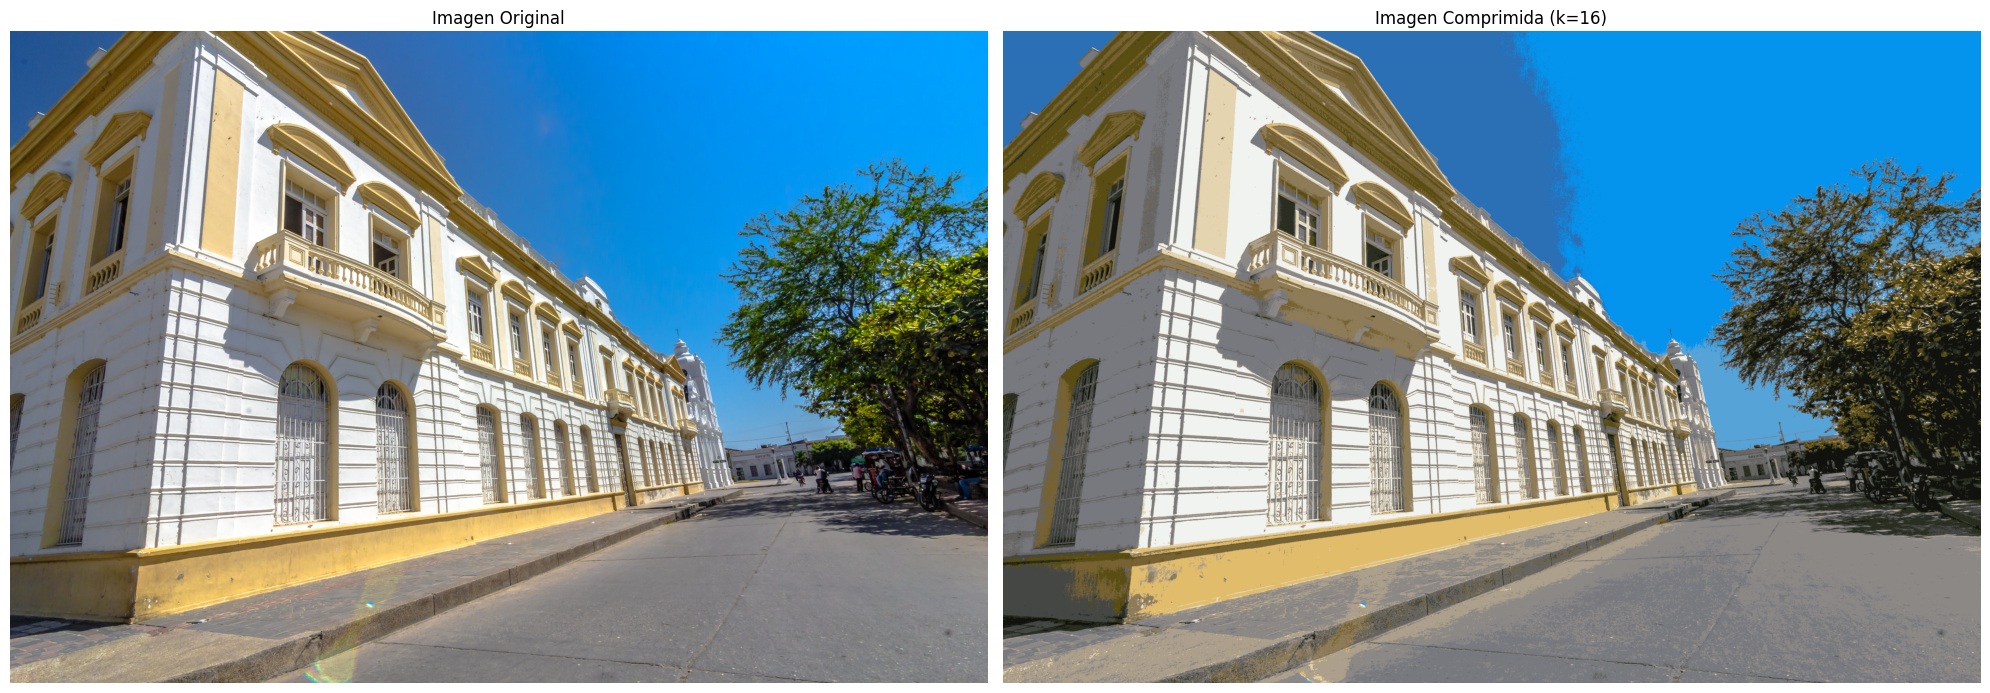

array([[[ 43, 111, 181],
        [ 43, 111, 181],
        [ 43, 111, 181],
        ...,
        [  4, 147, 237],
        [  4, 147, 237],
        [  4, 147, 237]],

       [[ 43, 111, 181],
        [ 43, 111, 181],
        [ 43, 111, 181],
        ...,
        [  4, 147, 237],
        [  4, 147, 237],
        [  4, 147, 237]],

       [[ 43, 111, 181],
        [ 43, 111, 181],
        [ 43, 111, 181],
        ...,
        [  4, 147, 237],
        [  4, 147, 237],
        [  4, 147, 237]],

       ...,

       [[172, 159, 139],
        [172, 159, 139],
        [172, 159, 139],
        ...,
        [119, 121, 127],
        [119, 121, 127],
        [119, 121, 127]],

       [[172, 159, 139],
        [228, 213, 176],
        [172, 159, 139],
        ...,
        [140, 136, 134],
        [140, 136, 134],
        [119, 121, 127]],

       [[172, 159, 139],
        [172, 159, 139],
        [172, 159, 139],
        ...,
        [140, 136, 134],
        [140, 136, 134],
        [140, 136, 134]]

In [6]:
# Ejemplo de uso
# Comprimir imagen con determinación automática de k
comprimir_imagen('pl.jpg', 'imagen_comprimida_optima.png')